In [1]:
import os
import sys
import shutil
import platform
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
import numpy as np
import math
from scipy.interpolate import interp1d
#import ipywidgets as wdg  # Using the ipython notebook widgets
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import ccdproc
import scipy.signal

# usually not contained within anacondy, thus added manually

sys.path.append('/Users/Micha/Workspaces/python/spectroscopy')
from whsdadoslib.data import DataProcessing, DataFile
from whsdadoslib.report import Report
from whsdadoslib.show import Show
from whsdadoslib.calibration import CalibrationData
from whsdadoslib.targets import Targets
from whsdadoslib.processing import ProcessingData

In [2]:
# Settings for ALPHA Ori

plot_title = 'ALP ORI'
prefix = 'ALPORI_Light_30,000'
filename_pattern = 'ALPORI_Light_30,000secs_00000%03d.fits.gz'
filename_index = 208
exposure_time = 30.0
date_yyyymmdd = '20200207'
masterdark_file = 'masterdark_030sec.npy'
correct_dark = False
airmass_calibration_star = 1.0
airmass_star = 1.5
figure_width = 15
figure_height = 12
peaks = [1410, 1730, 1832, 2143, 2243, 2567, 3500]
lines = [6563,4861,4340,4102,(3933+3968)/2]
descs = ['H-alpha','H-beta','H-gamma','H-delta','Ca II H+K']

In [3]:
# derived via https://www.google.de/maps/place/51°23'37.4%22N+6°58'43.0%22E/@51.3927894,6.9783578,138a,35y,39.46t/data=!3m1!1e3!4m13!1m6!3m5!1s0x47b8c35e2c65526f:0xe6c329dadcd6346a!2sSternwarte+Walter+Hohmann!8m2!3d51.3943807!4d6.978807!3m5!1s0x0:0x0!7e2!8m2!3d51.393716!4d6.9786111

observatory = {
    'name':'WHS',
    'earth_location': EarthLocation(
        lat=51.393716*u.deg, 
        lon=6.978611*u.deg, 
        height=120*u.m),
    'utc_offset':1*u.hour
}

In [4]:
from locallib.observatory import Observatory
whs = Observatory("whs.json")
print (whs.dict())

{'name': 'WHS', 'earth_location': <EarthLocation (3958426.20113413, 484533.69952253, 4961086.52908155) m>, 'utc_offset': <Quantity 1. h>}


In [5]:
if 'Venus' in platform.node():
    src_path = os.path.join('/Users','Micha','data',date_yyyymmdd,'src')
    fits_path  = os.path.join('/Users','Micha','data',date_yyyymmdd,'data')
    corr_path = os.path.join('/Users','Micha','data',date_yyyymmdd,'corr')
    products_path = os.path.join('/Users','Micha','data',date_yyyymmdd,'products')
else:
    src_path = os.path.join('d:/','Workspaces','data',date_yyyymmdd,'src')
    fits_path = os.path.join('d:/','Workspaces','data',date_yyyymmdd,'data')
    corr_path = os.path.join('d:/','Workspaces','data',date_yyyymmdd,'corr')
    products_path = os.path.join('d:/','Workspaces','data',date_yyyymmdd,'products')


ProcessingData.set_fits_path(fits_path)
ProcessingData.set_corr_path(corr_path)
ProcessingData.set_products_path(products_path)

In [43]:
targets = Targets()
os.chdir(src_path)
targets.update()



{'ALPAQL': {'fullname': 'alpha_aquilae',
  'ra.hms': '297d41m44.9783s',
  'dec.dms': '8d52m05.9563s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (297.69582731, 8.86832119)>},
 'GAMCAS': {'fullname': 'gamma_cassiopeiae',
  'ra.hms': '14d10m37.9755s',
  'dec.dms': '60d43m00.265s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (14.17721542, 60.71674028)>},
 'DELCEP': {'fullname': 'delta_cephei',
  'ra.hms': '337d17m33.9753s',
  'dec.dms': '58d24m54.7139s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (337.29277092, 58.41519831)>},
 'ALPCMI': {'fullname': 'alpha_canis_majoris',
  'ra.hms': '101d17m13.7592s',
  'dec.dms': '-16d42m58.0171s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (101.28715533, -16.71611586)>},
 'PCYG': {'fullname': 'P_cygni',
  'ra.hms': '304d26m48.0313s',
  'dec.dms': '38d01m58.5527s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (304.446

In [7]:
cwd = os.getcwd()
os.chdir(products_path)
masterdark = np.load(masterdark_file)
os.chdir(cwd)

In [8]:
icl = ccdproc.ImageFileCollection(
    fits_path,
    glob_include=prefix + '*.fit')

In [9]:
for fnames in icl.summary['file']:
    print (fnames)
factors = [1.0 for fname in  icl.summary['file']]

ALPORI_Light_30,000secs_00000207.fit
ALPORI_Light_30,000secs_00000208.fit
ALPORI_Light_30,000secs_00000209.fit
ALPORI_Light_30,000secs_00000210.fit
ALPORI_Light_30,000secs_00000211.fit
ALPORI_Light_30,000secs_00000212.fit
ALPORI_Light_30,000secs_00000213.fit
ALPORI_Light_30,000secs_00000214.fit
ALPORI_Light_30,000secs_00000215.fit
ALPORI_Light_30,000secs_00000216.fit


In [10]:
if correct_dark == True:
    dp = DataProcessing(masterdark=masterdark)
    dp.correct_dark(icl, plot=True, fliplr=False)

In [44]:
DataFile.update_fits_header(fits_path,icl,targets,whs.dict())

ALPORI_Light_30,000secs_00000207.fitss
ALPORI_Light_30,000secs_00000208.fitss
ALPORI_Light_30,000secs_00000209.fitss
ALPORI_Light_30,000secs_00000210.fitss
ALPORI_Light_30,000secs_00000211.fitss
ALPORI_Light_30,000secs_00000212.fitss
ALPORI_Light_30,000secs_00000213.fitss
ALPORI_Light_30,000secs_00000214.fitss
ALPORI_Light_30,000secs_00000215.fitss
ALPORI_Light_30,000secs_00000216.fitss


In [45]:
icl = ccdproc.ImageFileCollection(
    fits_path,
    glob_include=prefix + '*.fits')


In [46]:
report = Report(observatory=whs.dict())
report.list_measurements(icl, targets)

n   file                                 target     DATE-OBS                 alt        secz     °C   
  0 ALPORI_Light_30,000secs_00000207.fits ALPORI     2020-02-07T20:09:58.345   46.0 deg  1.39070 -10.5
  1 ALPORI_Light_30,000secs_00000208.fits ALPORI     2020-02-07T20:11:03.484   46.0 deg  1.39050 -10.0
  2 ALPORI_Light_30,000secs_00000209.fits ALPORI     2020-02-07T20:11:35.895   46.0 deg  1.39041 -10.0
  3 ALPORI_Light_30,000secs_00000210.fits ALPORI     2020-02-07T20:12:08.464   46.0 deg  1.39032 -10.1
  4 ALPORI_Light_30,000secs_00000211.fits ALPORI     2020-02-07T20:12:40.911   46.0 deg  1.39025  -9.8
  5 ALPORI_Light_30,000secs_00000212.fits ALPORI     2020-02-07T20:13:13.401   46.0 deg  1.39017 -10.0
  6 ALPORI_Light_30,000secs_00000213.fits ALPORI     2020-02-07T20:13:45.924   46.0 deg  1.39011 -10.0
  7 ALPORI_Light_30,000secs_00000214.fits ALPORI     2020-02-07T20:14:18.338   46.0 deg  1.39005 -10.0
  8 ALPORI_Light_30,000secs_00000215.fits ALPORI     2020-02-07T20:14:50.

In [12]:
show = Show()

754368
1756432
1717792
1208416
1033776
1759040
679680
1066688
1513872
1582800


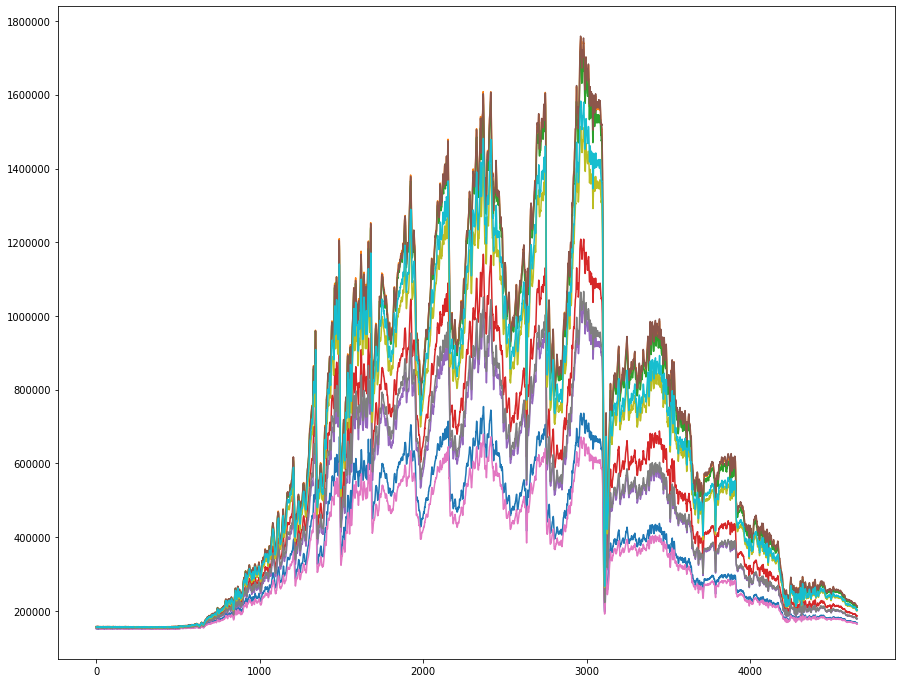

In [13]:
show.plots(icl, ylim=[peaks[2], peaks[3]], factors=factors)

In [14]:
filename = filename_pattern % (filename_index)
star = DataFile(filename, fits_path=corr_path)
star.read()

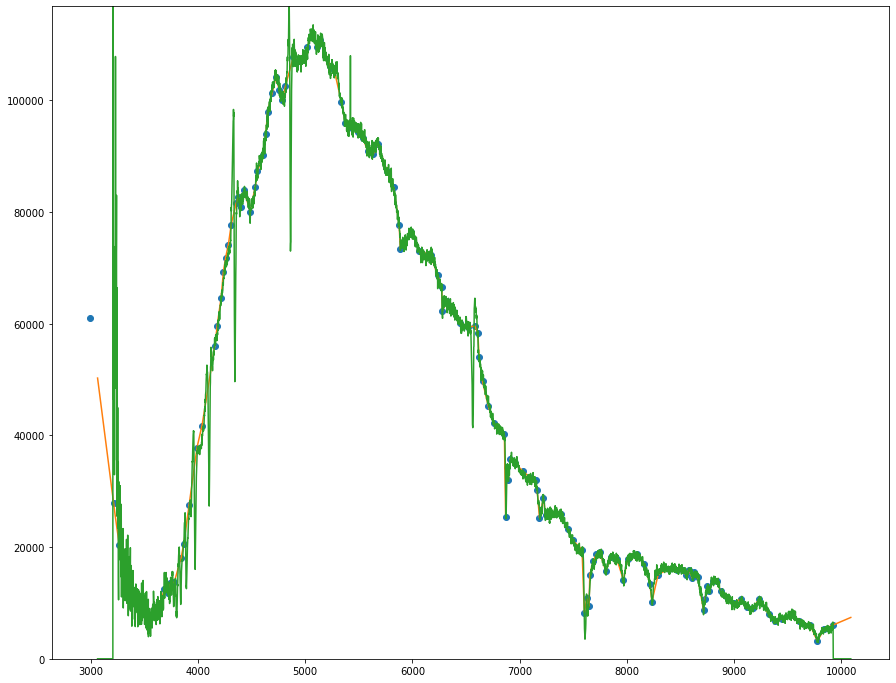

In [15]:
plt.rcParams['figure.figsize'] = [Show.figure_width, Show.figure_height]

os.chdir(src_path)
waves, instr_waves = CalibrationData.get_instrumentfunction()

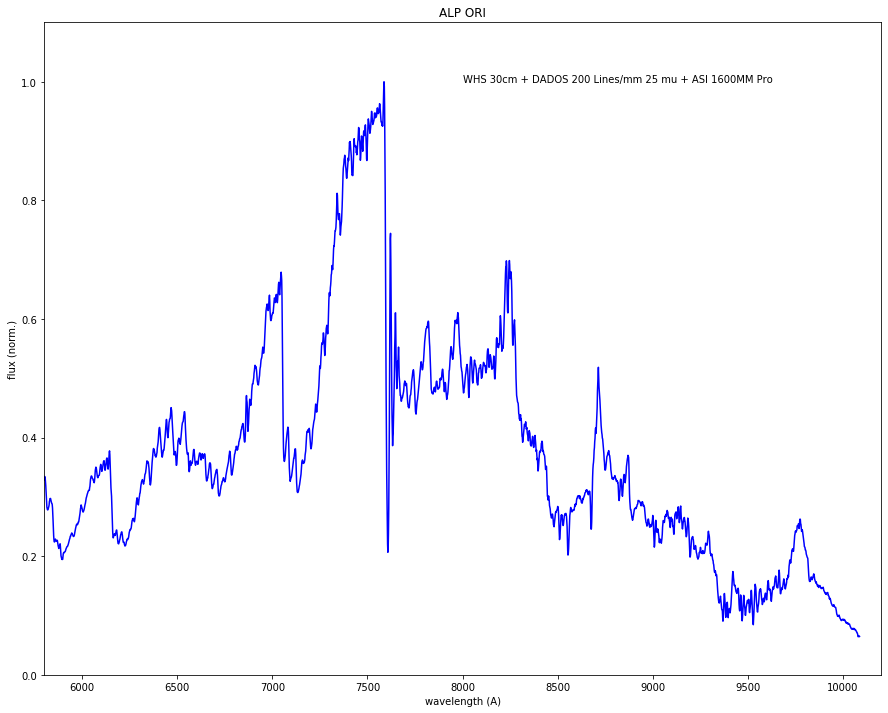

In [16]:
plt.rcParams['figure.figsize'] = [figure_width, figure_height]
fig, ax = plt.subplots()
traces_star = star.data[peaks[2]: peaks[3],:].sum(axis=0)
flux_star = []

for i in range(0,len(waves)):
    if instr_waves[i] == 0.0:
        flux_star.append(0.0)
    else:
        flux_star.append(traces_star[i]/instr_waves[i]/waves[i]/waves[i])

#plt.plot(waves,flux_alpaql, color='blue')

ext_path = os.path.join('/Users', 'Micha', 'data', 'ref', 'atmosphericextinction')
extinctionfile='paranal_extinction.dat'
wavelengths = []
extcoeffs = []
currentdir = os.getcwd()
try:
    os.chdir(CalibrationData.ext_path)
    with open(extinctionfile,'r') as f:
        for line in f:
            tokens = line.split(' ')
            if len(tokens) == 2:
                wavelength, extcoeff = tokens
                #print (wave, extcoeff)
                wavelengths.append(float(wavelength))
                extcoeffs.append(float(extcoeff))
finally:
            os.chdir(currentdir)
ext_std = interp1d(wavelengths, extcoeffs, fill_value="extrapolate")                
n_div = [math.exp(-0.4 * ext_std(wave)*airmass_calibration_star)/math.exp(-0.4 * ext_std(wave)*airmass_star) for wave in waves]
flux_star_extcorr = []
for i in range(0,len(waves)):
    flux_star_extcorr.append(flux_star[i] * n_div[i])
max_i = max(flux_star_extcorr)
plt.plot(waves,flux_star_extcorr/max_i, color='blue')   
plt.ylim(0,1.1)
plt.xlim(5800,10200)
plt.xlabel('wavelength (A)')
plt.ylabel('flux (norm.)')
plt.title(plot_title)
plt.text(8000,1.0,'WHS 30cm + DADOS 200 Lines/mm 25 mu + ASI 1600MM Pro', color='black')

#for line, desc in zip(lines,descs):
#    plt.text(line,0.2,desc,rotation=90)
plt.show()